In [19]:
#!/usr/bin/env python3

%reload_ext autoreload
%autoreload 2

# Maths
import numpy as np

# PCovR utilities
from regression import LR, KRR, SparseKRR, PCovR, KPCovR, SparseKPCovR
from decomposition import PCA, KPCA, SparseKPCA
from kernels import linear_kernel, gaussian_kernel, center_kernel
from tools import FPS, simple_split

# ASE
from ase.io import read, write

# SOAP
from rascal.representations import SphericalInvariants as SOAP

# Scikit learn
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA as skPCA
from sklearn.decomposition import KernelPCA as skKPCA

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# Make the plots look nicer
plot_parameters = {
    'lines.linewidth': 1.0,
    'lines.markersize': 2,
    'patch.linewidth': 1.0,
    'hatch.linewidth': 1.0,
    'axes.linewidth': 1.0,
    'xtick.top': True,
    'xtick.bottom': True,
    'xtick.direction': 'in',
    'xtick.minor.visible': True,
    'xtick.major.size': 4.0,
    'xtick.minor.size': 2.0,
    'xtick.major.pad': 5.0,
    'xtick.minor.pad': 5.0,
    'ytick.left': True,
    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.minor.visible': True,
    'ytick.major.size': 4.0,
    'ytick.minor.size': 2.0,
    'ytick.major.pad': 5.0,
    'ytick.minor.pad': 5.0   
}

for pp in plot_parameters.keys():
    mpl.rcParams[pp] = plot_parameters[pp]

In [20]:
# Read xyz files
s = read('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/KernelPCovR/datasets/CSD-1000R.xyz', index=':5')

# Extract chemical shifts
cs = []
for ss in s:
    ss.wrap()
    cs.append(ss.arrays['CS_local'])

In [21]:
# Compute SOAPs (from librascal tutorial)
soap = SOAP(soap_type='PowerSpectrum',
           interaction_cutoff=3.5,
           max_radial=6,
           max_angular=6,
           gaussian_sigma_type='Constant',
           gaussian_sigma_constant=0.4,
           cutoff_smooth_width=0.5)

In [22]:
soap_rep = soap.transform(s)

In [23]:
X = soap_rep.get_features(soap)
Y = np.concatenate(cs)

In [24]:
# Train-Test split
f_train = 0.80
X_train, X_test, Y_train, Y_test = simple_split(X, Y, f_train)

In [26]:
# Select FPS components from train set
n_FPS = 200
idxs, d = FPS(X_train.T, n_FPS)

X_train = X_train[:, idxs]
X_test = X_test[:, idxs]

In [27]:
# Center the data
X_mean = np.mean(X_train, axis=0)
Y_mean = np.mean(Y_train)

X_train -= X_mean
X_test -= X_mean
Y_train -= Y_mean
Y_test -= Y_mean

# PCA

In [28]:
# PCA
pca = PCA(n_pca=2)
pca.fit(X_train)

Xpca = pca.transform(X_test)
Xrpca = pca.inverse_transform(X_test)

In [32]:
# sk-learn PCA
skpca = skPCA(n_components=2)
skpca.fit(X_train)
Xskpca = skpca.transform(X_test)

# Inverse transform
Xrskpca = skpca.inverse_transform(Xskpca)

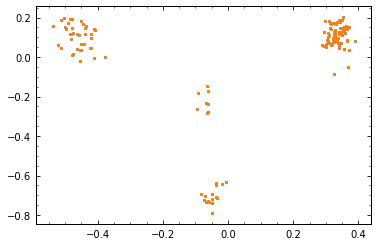

In [34]:
plt.scatter(Xpca[:, 0], Xpca[:, 1])
plt.scatter(Xskpca[:, 0], Xskpca[:, 1])
plt.show()

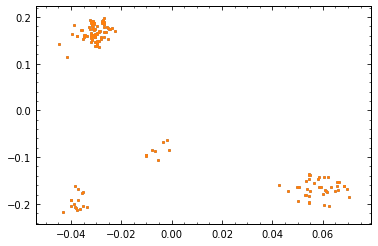

In [37]:
plt.scatter(Xrpca[:, 0], Xrpca[:, 1])
plt.scatter(Xrskpca[:, 0], Xrskpca[:, 1])
plt.show()

# Linear Regression

In [38]:
# LR
lr = LR()
lr.fit(X_train, Y_train)
Yplr = lr.transform(X_test)

In [40]:
# scikit-learn LR
sklr = LinearRegression()
sklr.fit(X_train, Y_train)
Ypsklr = sklr.predict(X_test)

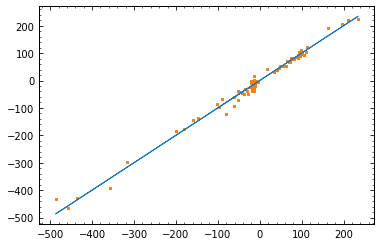

In [197]:
plt.scatter(Y_test, Yplr)
plt.scatter(Y_test, Ypsklr)
plt.plot(Y_test, Y_test)
plt.show()

# KPCA

In [170]:
# Build kernels
K_train = gaussian_kernel(X_train, X_train)
K_test = gaussian_kernel(X_test, X_train)

K_test = center_kernel(K_test, K_ref=K_train)
K_train = center_kernel(K_train)

In [171]:
# KPCA
kpca = KPCA(n_kpca=2)

kpca.fit(K_train)
T = kpca.transform(K_train)
Xkpca = kpca.transform(K_test)

# Inverse transform
KTT = gaussian_kernel(T, T)
KXT = gaussian_kernel(Xkpca, T)
KXT = center_kernel(KXT, K_ref=KTT)
KTT = center_kernel(KTT)
Xrkpca = kpca.inverse_transform(KTT, KXT, X_train)

In [183]:
# scikit-learn KPCA
skkpca = skKPCA(n_components=2, kernel='rbf', gamma=1.0, alpha=1.0E-12, fit_inverse_transform=True)
skkpca.fit(X_train)

Xskkpca = skkpca.transform(X_test)
Xrskkpca = skkpca.inverse_transform(Xskkpca)

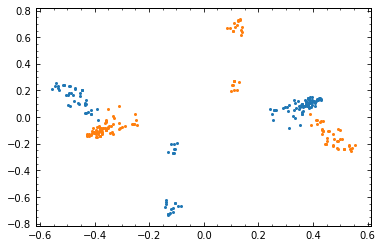

In [196]:
plt.scatter(Xkpca[:, 0], Xkpca[:, 1])
plt.scatter(Xskkpca[:, 0], Xskkpca[:, 1])
plt.show()

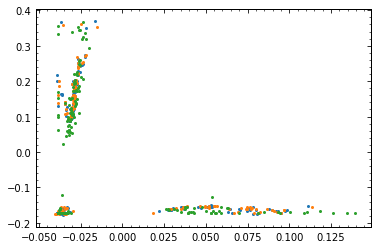

In [185]:
plt.scatter(Xrkpca[:, 0], Xrkpca[:, 1])
plt.scatter(Xrskkpca[:, 0], Xrskkpca[:, 1])
plt.scatter(X_test[:, 0], X_test[:, 1])
plt.show()

# KRR

In [186]:
# KRR
krr = KRR()
krr.fit(K_train, Y_train)
Ypkrr = krr.transform(K_test)

In [193]:
# scikit-learn KRR
skkrr = KernelRidge(kernel='rbf', gamma=1.0, alpha=1.0E-12)
skkrr.fit(X_train, Y_train)
Ypskrr = skkrr.predict(X_test)

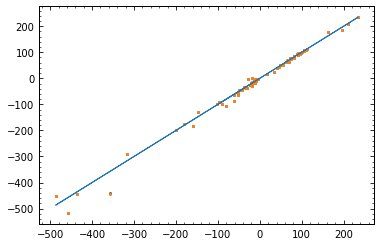

In [194]:
plt.scatter(Y_test, Ypkrr)
plt.scatter(Y_test, Ypskrr)
plt.plot(Y_test, Y_test)
plt.show()

# Sparse KPCA

In [311]:
idxs, _ = FPS(X_train, 200)
Xs_train = X_train[idxs, :]

In [312]:
# Build sparse kernels
KMM = gaussian_kernel(Xs_train, Xs_train)
KNM_train = gaussian_kernel(X_train, Xs_train)
KNM_test = gaussian_kernel(X_test, Xs_train)

KNM_train = center_kernel(KNM_train, K_ref=KMM)
KNM_test = center_kernel(KNM_test, K_ref=KMM)
KMM = center_kernel(KMM)

In [295]:
# Sparse KPCA
kpca_sparse = SparseKPCA(n_kpca=2)
kpca_sparse.fit(KNM_train, KMM)
Xskpca = kpca_sparse.transform(KNM_test)
Ts = kpca_sparse.transform(KNM_train)
Ms = kpca_sparse.transform(KMM)

# Inverse transform
KTM = gaussian_kernel(Ts, Ms)
KMMs = gaussian_kernel(Ms, Ms)
KXM = gaussian_kernel(Xskpca, Ms)
KTM = center_kernel(KTM, K_ref=KMMs)
KXM = center_kernel(KXM, K_ref=KMMs)
KMMs = center_kernel(KMMs)

Xrskpca = kpca_sparse.inverse_transform(KTM, KMMs, KXM, X_train, sigma=1E-15)

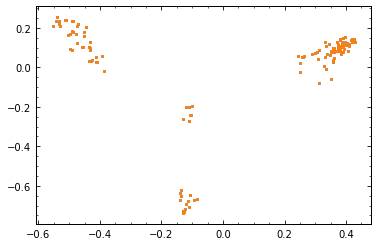

In [296]:
plt.scatter(Xskpca[:, 0], Xskpca[:, 1])
plt.scatter(Xkpca[:, 0], Xkpca[:, 1])
plt.show()

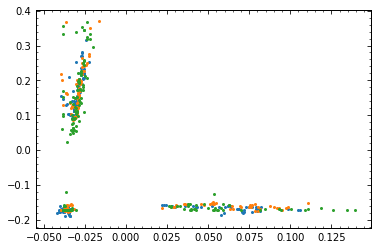

In [297]:
plt.scatter(Xrskpca[:, 0], Xrskpca[:, 1])
plt.scatter(Xrkpca[:, 0], Xrkpca[:, 1])
plt.scatter(X_test[:, 0], X_test[:, 1])
plt.show()

# Sparse KRR

In [313]:
# Sparse KRR
skrr = SparseKRR(sigma=1E-15)
skrr.fit(KNM_train, KMM, Y_train)
Ypskrr = skrr.transform(KNM_test)

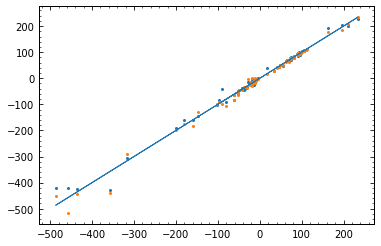

In [315]:
plt.scatter(Y_test, Ypskrr)
plt.scatter(Y_test, Ypkrr)
plt.plot(Y_test, Y_test)
plt.show()

# PCovR

In [316]:
# PCovR limiting cases
pcovr0 = PCovR(alpha=0.0, n_pca=None)
pcovr1 = PCovR(alpha=1.0, n_pca=None)

In [317]:
pcovr0.fit_feature_space(X_train, Y_train)
pcovr1.fit_feature_space(X_train, Y_train)

In [318]:
Xp = pcovr1.transform_X(X_test)
Yp = pcovr0.transform_Y(X_test)

# Inverse transform
Xr = pcovr1.inverse_transform_X(X_test)

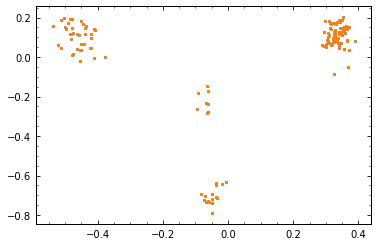

In [319]:
plt.scatter(Xp[:, 0], Xp[:, 1])
plt.scatter(Xpca[:, 0], Xpca[:, 1])
plt.show()

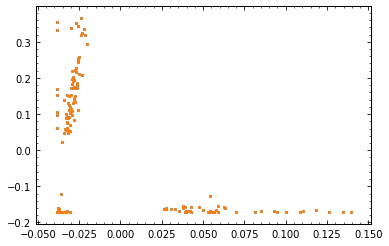

In [322]:
plt.scatter(Xr[:, 0], Xr[:, 1])
plt.scatter(X_test[:, 0], X_test[:, 1])
plt.show()

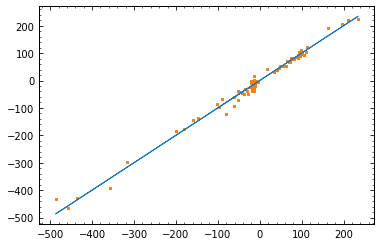

In [324]:
plt.scatter(Y_test, Yp)
plt.scatter(Y_test, Yplr)
plt.plot(Y_test, Y_test)
plt.show()

# Kernel PCovR

In [334]:
# KPCovR limiting cases
kpcovr0 = KPCovR(alpha=0.0, n_kpca=2)
kpcovr1 = KPCovR(alpha=1.0, n_kpca=2)

In [335]:
kpcovr0.fit(K_train, Y_train)
kpcovr1.fit(K_train, Y_train, X=X_train)

In [336]:
Xkp = kpcovr1.transform_K(K_test)
Ykp = kpcovr0.transform_Y(K_test)

# Inverse transform
Krkp = kpcovr1.inverse_transform_K(K_test)
Xrkp = kpcovr1.inverse_transform_X(K_test)

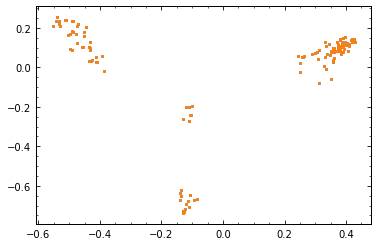

In [337]:
plt.scatter(Xkp[:, 0], Xkp[:, 1])
plt.scatter(Xkpca[:, 0], Xkpca[:, 1])
plt.show()

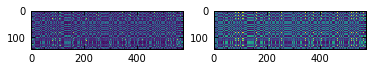

17.854304201580213


In [338]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(K_test)
axs[1].imshow(Krkp)
plt.show()
print(np.linalg.norm(K_test-Krkp))

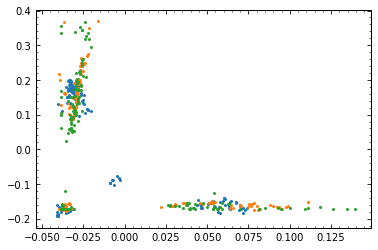

In [345]:
plt.scatter(Xrkp[:, 0], Xrkp[:, 1])
plt.scatter(Xrkpca[:, 0], Xrkpca[:, 1])
plt.scatter(X_test[:, 0], X_test[:, 1])
plt.show()

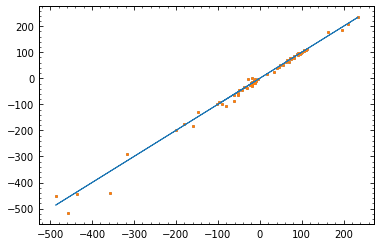

In [340]:
plt.scatter(Y_test, Ykp)
plt.scatter(Y_test, Ypkrr)
plt.plot(Y_test, Y_test)
plt.show()

# Sparse KPCovR

In [424]:
skpcovr0 = SparseKPCovR(alpha=0.0, n_kpca=2, sigma=1E-5)
skpcovr1 = SparseKPCovR(alpha=1.0, n_kpca=2, sigma=1E-5)

In [425]:
skpcovr0.fit(KNM_train, KMM, Y_train)
skpcovr1.fit(KNM_train, KMM, Y_train, X=X_train)

In [426]:
Xskp = skpcovr1.transform_K(KNM_test)
Yskp = skpcovr0.transform_Y(KNM_test)

# Inverse transform
Krskp = skpcovr1.inverse_transform_K(KNM_test)
Xrskp = skpcovr1.inverse_transform_X(KNM_test)

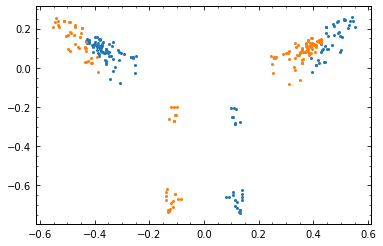

In [427]:
plt.scatter(Xskp[:, 0], Xskp[:, 1])
plt.scatter(Xkpca[:, 0], Xkpca[:, 1])
plt.show()

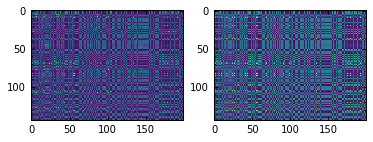

10.777916644877587


In [428]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(KNM_test)
axs[1].imshow(Krskp)
plt.show()
print(np.linalg.norm(KNM_test-Krskp))

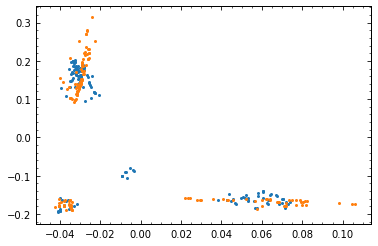

In [429]:
plt.scatter(Xrskp[:, 0], Xrskp[:, 1])
plt.scatter(Xrskpca[:, 0], Xrskpca[:, 1])
#plt.scatter(X_test[:, 0], X_test[:, 1])
plt.show()

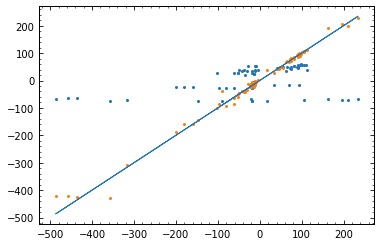

In [430]:
# TODO: when to truncate in the PCAs and PCovRs?
plt.scatter(Y_test, Yskp)
plt.scatter(Y_test, Ypskrr)
plt.plot(Y_test, Y_test)
plt.show()